# Unit Commitment problem using Quantum Annealers

This notebook delves into the realm of quantum annealing in the context of power systems optimization. Quantum annealing, a cutting-edge approach rooted in quantum computing principles, offers a new perspective on solving complex optimization problems with unprecedented efficiency. We extend the foundations of the economic dispatch (ED) model by leveraging quantum annealing to address commitment decisions, constraints, and costs associated with generators using D-Wave Advantage. 

## Introduction: Quantum Annealing and Power Systems Optimization

Power systems face mounting challenges in meeting growing energy demands while ensuring economic viability and sustainability. Quantum annealing emerges as a promising avenue that harnesses the intrinsic properties of quantum mechanics to revolutionize optimization processes.

Quantum annealing exploits the fundamental quantum phenomenon of superposition and entanglement to navigate complex solution spaces more effectively than classical computing methods. This unique approach allows us to tackle intricate optimization problems that were previously deemed intractable or resource-intensive.

Our project builds upon the economic dispatch model, a cornerstone in power systems optimization, and integrates the novel paradigm of quantum annealing. We embark on a multi-stage journey, progressively enhancing the ED model to incorporate commitment decisions, ramp constraints, and the intricate interplay of generator operations. As we navigate this exploration, we are mindful of the potential computational trade-offs and the transformative impact that quantum annealing brings to the table.

## Problem formulation

We start with a simple formulation of the problem which aims at minimising the cost of operating power plants, while meeting energy demand and subject to energy bounds.


$$
\begin{align}
\min OC = \ & \sum_{g \in G, t \in T} VarCost(g) \times GEN(g,t) + \sum_{g \in G_{thermal}, t \in T} StartUpCost(g) \times START(g,t) \\
\end{align}
$$
$$
\begin{align}
\text{s.t.} & \\
 & \sum_{g} GEN(g,t)  = Demand(T) & \forall \quad t \in T \\
 & GEN(g,t)  \leq Pmax(g,t)  & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN(g,t)  \geq Pmin(g,t)  & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN(g,t)  \leq Pmax(g,t)  \times COMMIT(g,t)  & \forall \quad g \in G_{thermal} , t \in T \\
 & GEN(g,t)  \geq Pmin(g,t)  \times COMMIT(g,t)  & \forall \quad g \in G_{thermal} , t \in T \\
 & COMMIT(g,t)  \geq \sum_{t'≥t-MinUp(g)}^{t} START(g,t)  & \forall \quad g \in G_{thermal} , t \in T \\
 & 1-COMMIT(g,t)  \geq \sum_{t'≥t-MinDown(g)}^{t} SHUT(g,t)  &\forall \quad g \in G_{thermal} , t \in T \\
  & COMMIT(g,t+1) - COMMIT(g,t)  =&\\
 & \quad START(g,t+1) - SHUT(g,t+1) &\forall \quad G_{thermal} \in G , t = 1...T-1 
\end{align}
$$

where $OC$ is the operating cost.


The **decision variables** in the above problem:

- $GEN(G)$, generation (in MW) produced by each generator, $g$
- $START(g,t)$, startup decision (binary) of thermal generator $g$ at time $t$
- $SHUT(g,t)$, shutdown decision (binary) of thermal generator $g$ at time $t$
- $COMMIT(g,t)$, commitment status (binary) of generator $g$ at time $t$

The **parameters** are:

- $Pmin(g)$, the minimum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Pmax(g)$, the maximum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Demand$, the demand (in MW)
- $VarCost(g) = VarOM(g) + HeatRate(g) \times FuelCost(g)$, the variable cost of generator $g$ 
- $StartUpCost(g)$, the startup cost of generator $g$
- $MinUp(g)$, the minimum up time of generator $g$, or the minimum time after start-up before a unit can shut down
- $MinDown(g)$, the minimum down time of generator $g$, or the minimum time after shut-down before a unit can start again

In addition, we introduce a few different sets:

- $G$, the set of all generators
- $G_{thermal} \subset G$, the subset of thermal generators for which commitment is necessary
- $T$, the set of all time periods over which we are optimizing commitment and dispatch decisions

Finally, the **three-variable commitment equations** capture the basic logic of commitment:

- Units incur costs when they startup (not when they shutdown)
- Units must stay on (and off) for a minimum period of time&mdash;in lieu of explicitly enforcing a startup trajectory
- Some summations (simplified here) will need to be modified near the beginning of the time period

### 1. Import packages

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pulp import *

import os
from dwave.system import LeapHybridCQMSampler
from dimod import QuadraticModel, ConstrainedQuadraticModel, Binary, Integer
os.environ['DWAVE_API_TOKEN'] = 'DEV-4b730cacad4155ed785fe855ef53a8d4bbfd80e9'

### 2. Import and preprocess data

We will use data from [power-system-optimization](https://github.com/east-winds/power-systems-optimization) repository. This dataset was obtained from San Diego Gas and Electric (SDG&E, via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform), consisting of:

- 33 generators
- estimated hourly demand for 2020 (net load at the transmission substation level after subtracting 600MW of behind-the-meter solar from original demand)
- variable generation capacity factors
- estimated natural gas fuel costs

In [89]:
# import data
demand = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Demand.csv')
fuel_data = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Fuels_data.csv')
generators = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Generators_data.csv')

In [90]:
# Merge the two DataFrames based on the 'Fuel' column
generators = pd.merge(generators, fuel_data, on='Fuel', how='left')

In [91]:
# remove generators with no capacity
generators = generators[generators['Existing_Cap_MW'] > 0]

In [92]:
# Define the resource types to classify
resource_types = ['onshore_wind_turbine', 'small_hydroelectric', 'solar_photovoltaic']

# Create a new column 'IsClassified' based on the specified conditions
generators['IsClassified'] = np.where(generators['Resource'].isin(resource_types), True, False)

In [94]:
# We only want to keep the generators for which commitment is necessary
thermal_generators = generators[generators['Up_time']>0]
non_var_generators = generators[generators['IsClassified'] == False]
var_generators = generators[generators['IsClassified'] == True]

### 3. Quantum annealing implementation

We will calculate a day's unit commitmment using 10 generators

In [99]:
n_hours = 24   # number of time hours
num_generators = 10   # number of generators
day_demand = demand['Demand'][:n_hours].values - 1000   # rescaled day demand

1. Define the variables

In [17]:
# define a constrained quadratic model instance
cqm = ConstrainedQuadraticModel()

#define the commitment variable
commit = {(n, t): Binary('x_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

#define the generation variable 
gen = {(n, t): Integer('y_{}_{}'.format(n, t)) for n, rows in generators.iterrows() for t in range(n_hours)}

#define the start up variable 
start = {(n, t): Binary('z_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

#define the shut down variable 
shut = {(n, t): Binary('w_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

2. Define the objective function:

In [19]:
operating_cost = QuadraticModel()

# non_varying generators
for generator, row in non_var_generators.iterrows():
    for hour in range(n_hours):
        heat_rate = non_var_generators['Heat_rate_MMBTU_per_MWh'][generator]
        fuel_cost = non_var_generators['Cost_per_MMBtu'][generator]
        VarOM = non_var_generators['Var_OM_cost_per_MWh'][generator]
        operating_cost.update((heat_rate * fuel_cost + VarOM) * gen[generator, hour])

# varying generators
for generator, row in var_generators.iterrows():
    for hour in range(n_hours):
        VarOM = var_generators['Var_OM_cost_per_MWh'][generator]
        operating_cost.update(VarOM * gen[generator, hour])

#thermal generators
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        existing_cap = thermal_generators['Existing_Cap_MW'][generator]
        start_cost = thermal_generators['Start_cost_per_MW'][generator]
        operating_cost.update(existing_cap * start_cost * start[generator, hour])

cqm.set_objective(operating_cost)

3. Define energy demand constraints

In [23]:
# thermal generators requiring commitment
for hour in range(n_hours):
    sum_energies = QuadraticModel()
    for generator, row in generators.iterrows():
        sum_energies += gen[generator, hour]
    cqm.add_constraint(sum_energies == day_demand[hour], label = f'energy demand hour {hour}')

In [ ]:
# TO DO: non-variable generation not requiring commitment

In [ ]:
# TO DO variable generation, accounting for hourly capacity factor

4. Define capacity constraints

In [50]:
#define the energy bounds
for hour in range(n_hours):
    for generator, row in thermal_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        min_power = row['Min_power']
        
        cqm.add_constraint(gen[generator, hour] - commit[generator, hour] * existing_cap * min_power  >= 0,
                           label = f'energy lower bound generator {generator} at {hour}')
        
        cqm.add_constraint(gen[generator, hour] - commit[generator, hour] * existing_cap <= 0,
                           label = f'energy upper bound generator {generator} at {hour}')

5. Unit commitment constraints

In [35]:
# minimum up and down time
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        if hour >= row['Up_time']:
            cqm.add_constraint(commit[generator, hour] - sum(start[generator, t] for t in range(hour - row['Up_time'], hour)) >= 0,
                               label = f'start time of generator {generator} at {hour}')
        if hour >= row['Down_time']:
            cqm.add_constraint(1 - commit[generator, hour] - sum(shut[generator, t] for t in range(hour - row['Down_time'], hour)) >= 0,
                               label = f'shut time of generator {generator} at {hour}')

TypeError: ConstrainedQuadraticModel.add_constraint_from_iterable() missing 1 required positional argument: 'sense'

In [52]:
# Commmitment state
for hour in range(1, n_hours):
    for generator, row in thermal_generators.iterrows():
        cqm.add_constraint(commit[generator, hour]  - commit[generator, hour - 1] - start[generator, hour] + shut[generator, hour] == 0,
                           label = f'commitment state generator {generator} at {hour}')

6. Sample the problem using the LeapHybridCQMSampler

In [53]:
#sample 
sampler = LeapHybridCQMSampler()
raw_sampleset = sampler.sample_cqm(cqm)

7. Obtain the best sample

In [96]:
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
num_feasible = len(feasible_sampleset)
if num_feasible > 0:
    best_samples = \
        feasible_sampleset.truncate(min(10, num_feasible))
else:
    best_samples = raw_sampleset.truncate(10)

print(" \n" + "=" * 30 + "BEST SAMPLE SET" + "=" * 30)
print(best_samples)

best_sample = best_samples.first.sample
# Separate x and y variables into two dictionaries
commit_results = {}
gen_results = {}
start_results = {}
shut_results = {}

for key, value in best_sample.items():
    if key.startswith('x'):
        commit_results[key] = value
    elif key.startswith('y'):
        gen_results[key] = value
    elif key.startswith('z'):
        start_results[key] = value
    elif key.startswith('w'):
        shut_results[key] = value

 
==============================BEST SAMPLE SET==============================
  w_10_0 w_10_1 w_10_10 w_10_11 w_10_12 ... z_9_9       energy num_oc. ...
0    0.0    0.0     0.0     0.0     1.0 ...   0.0 1015799.4444       1 ...
1    0.0    0.0     0.0     0.0     1.0 ...   0.0 1015799.4444       1 ...
2    0.0    0.0     0.0     0.0     0.0 ...   0.0 1032373.1725       1 ...
3    0.0    0.0     0.0     0.0     0.0 ...   0.0 1032373.1725       1 ...
4    0.0    0.0     0.0     0.0     0.0 ...   0.0 1069032.6865       1 ...
5    1.0    0.0     0.0     0.0     0.0 ...   0.0 1069032.6865       1 ...
6    0.0    0.0     0.0     0.0     0.0 ...   0.0 1085130.1128       1 ...
7    0.0    0.0     0.0     0.0     0.0 ...   0.0 1085130.1128       1 ...
8    0.0    0.0     0.0     0.0     1.0 ...   0.0 1097377.3621       1 ...
9    0.0    0.0     0.0     0.0     1.0 ...   0.0 1097377.3621       1 ...
['INTEGER', 10 rows, 10 samples, 2040 variables]


8. Unpack results

In [119]:
# Prepare the data
gens = []
times = []
energies = []
resource = []
status = []
cost = raw_sampleset.first.energy

for key, value in gen_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    gens.append(int(generator))
    times.append(int(time))
    energies.append(value)
    resource.append(generators['Resource'][int(generator)])

# Create a DataFrame
data_df = pd.DataFrame({
    'Generator': gens,
    'Resource' : resource,
    'Time': times,
    'Variables': len(best_samples.variables),
    'Generated Energy annealer': energies,
    'Status annealer': None,
    'Start': None,
    'Shut': None,
    'Cost annealer': cost
})

for key, value in commit_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    row_index = data_df[(data_df['Generator'] == int(generator)) & (data_df['Time'] == int(time))].index
    data_df.loc[row_index, 'Status annealer'] = value

for key, value in start_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    row_index = data_df[(data_df['Generator'] == int(generator)) & (data_df['Time'] == int(time))].index
    data_df.loc[row_index, 'Start'] = value

for key, value in shut_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    row_index = data_df[(data_df['Generator'] == int(generator)) & (data_df['Time'] == int(time))].index
    data_df.loc[row_index, 'Shut'] = value

9. Plot the generated energy

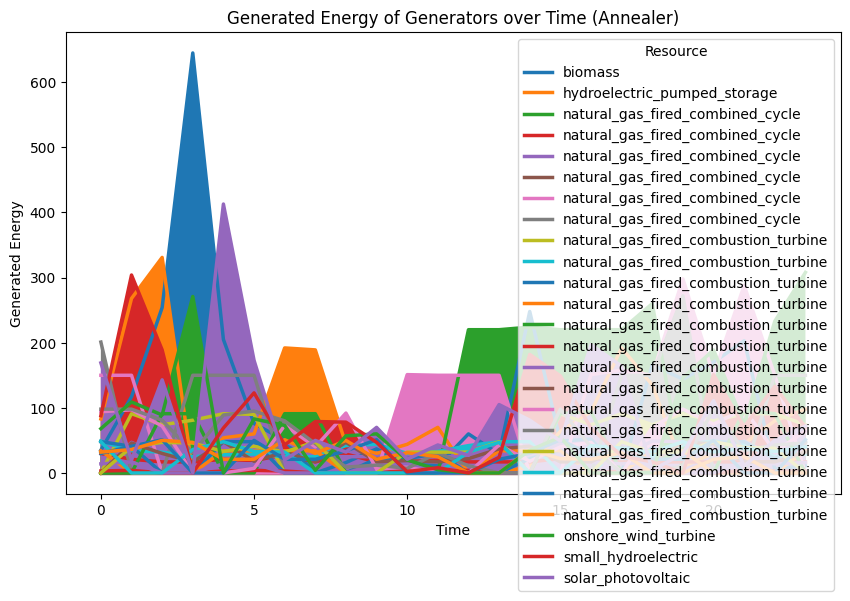

In [122]:
# Sort the DataFrame by the Generator and Time columns
data_df.sort_values(['Generator', 'Time'], inplace=True)

# Create the stacked area plot
plt.figure(figsize=(10, 6))
for generator, df_group in data_df.groupby('Generator'):
    sns.lineplot(x='Time', y='Generated Energy annealer', data=df_group, linewidth=2.5, label=df_group.iloc[0]['Resource'])
    plt.fill_between(df_group['Time'], df_group['Generated Energy annealer'], alpha=1)  # Fill area below the lines
plt.xlabel('Time')
plt.ylabel('Generated Energy')
plt.title('Generated Energy of Generators over Time (Annealer)')
plt.legend(title='Resource')
plt.show()

### 4. Classical implementation

1. Define the variables

In [157]:
# Create a MILP problem
prob = LpProblem("Unit_Commitment_Problem", LpMinimize)

# Decision variables
commit = LpVariable.dicts("x", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Binary")
gen = LpVariable.dicts("y", [(generator, t) for generator, rows in generators.iterrows() for t in range(n_hours)], cat="Integer")
start = LpVariable.dicts("z", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Binary")
shut = LpVariable.dicts("w", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Binary")

2. Define the objective function

In [158]:
# Initialize lists to store linear expressions for each term
non_varying_terms = []
varying_terms = []
thermal_terms = []

# non-varying generators
for generator, row in non_var_generators.iterrows():
    for hour in range(n_hours):
        heat_rate = non_var_generators['Heat_rate_MMBTU_per_MWh'][generator]
        fuel_cost = non_var_generators['Cost_per_MMBtu'][generator]
        VarOM = non_var_generators['Var_OM_cost_per_MWh'][generator]
        non_varying_terms.append((heat_rate * fuel_cost + VarOM) * gen[generator, hour])

# varying generators
for generator, row in var_generators.iterrows():
    for hour in range(n_hours):
        VarOM = var_generators['Var_OM_cost_per_MWh'][generator]
        varying_terms.append(VarOM * gen[generator, hour])

# thermal generators
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        existing_cap = thermal_generators['Existing_Cap_MW'][generator]
        start_cost = thermal_generators['Start_cost_per_MW'][generator]
        thermal_terms.append(existing_cap * start_cost * start[generator, hour])


# Add all terms using lpSum
total_obj = lpSum(non_varying_terms) + lpSum(varying_terms) + lpSum(thermal_terms)
prob += total_obj

3. Define energy demand constraints

In [159]:
# Define the energy demand constraint
for hour in range(n_hours):
    sum_energies = lpSum(gen[generator, hour] for generator, _ in generators.iterrows())
    prob += (sum_energies == day_demand[hour])

4. Define capacity constraints

In [160]:
# thermal generators requiring commitment
for hour in range(n_hours):
    for generator, row in thermal_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        min_power = row['Min_power']

        prob += lpSum([gen[generator, hour] - commit[generator, hour] * existing_cap * min_power]) >= 0
        prob += lpSum([gen[generator, hour] - commit[generator, hour] * existing_cap]) <= 0

In [162]:
# non-variable generation not requiring commitment
for hour in range(n_hours):
    for generator, row in non_var_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        prob += lpSum([gen[generator, hour] - existing_cap]) <= 0

In [ ]:
# TO DO variable generation, accounting for hourly capacity factor


5. Define unit commitment constraints

In [154]:
# minimum up and down time
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        if hour >= row['Up_time']:
            prob += lpSum(commit[generator, hour] - sum(start[generator, t] for t in range(hour - row['Up_time'], hour))) >= 0

        if hour >= row['Down_time']:
            prob += lpSum(1 - commit[generator, hour] - sum(shut[generator, t] for t in range(hour - row['Down_time'], hour))) <= 0

In [155]:
# Commmitment state
for hour in range(1, n_hours):
    for generator, row in thermal_generators.iterrows():
        prob += lpSum(commit[generator, hour]  - commit[generator, hour - 1] - start[generator, hour] + shut[generator, hour]) == 0

6. Solve the problem

In [161]:
# Solve the problem
prob.solve()

# Check the solution status
if LpStatus[prob.status] == 'Optimal':
    # Retrieve the optimal solution
    commit_solution = {(generator, t): commit[generator, t].varValue for generator, row in thermal_generators.iterrows() for t in range(n_hours)}
    gen_solution = {(generator, t): gen[generator, t].varValue for generator, row in thermal_generators.iterrows() for t in range(n_hours)}
    start_solution = {(generator, t): start[generator, t].varValue for generator, row in thermal_generators.iterrows() for t in range(n_hours)}
    shut_solution = {(generator, t): shut[generator, t].varValue for generator, row in thermal_generators.iterrows() for t in range(n_hours)}
    total_cost = value(prob.objective)
    print("Optimal solution found")
    print("Total cost:", total_cost)
else:
    print("No solution found")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juanfrancisco/Desktop/uc/uc-problem-annealing/env/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/2db7fa6611a74f089b67827bbdc9fd9c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/2db7fa6611a74f089b67827bbdc9fd9c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 989 COLUMNS
At line 7566 RHS
At line 8551 BOUNDS
At line 10112 ENDATA
Problem MODEL has 984 rows, 1560 columns and 2472 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is unbounded - 0.01 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

No solution found


In [54]:
commit_solution

NameError: name 'commit_solution' is not defined

In [38]:
data_df['Generated Energy classical'] = [y_solution.get((row['Generator'], row['Time']), 0.0) for index, row in data_df.iterrows()]
data_df['Generator status classical'] = [x_solution.get((row['Generator'], row['Time']), 0.0) for index, row in data_df.iterrows()]
data_df['Classical cost'] = total_cost

In [39]:
data_df

,Generator,Resource,Time,Variables,Generated Energy annealer,Status annealer,Cost annealer,Generated Energy classical,Generator status classical,Classical cost
48,2,natural_gas_fired_combined_cycle,0,480,565.0,1.0,630428.0919,607.0,1.0,609551.178
49,2,natural_gas_fired_combined_cycle,1,480,607.0,1.0,630428.0919,607.0,1.0,609551.178
60,2,natural_gas_fired_combined_cycle,2,480,560.0,1.0,630428.0919,607.0,1.0,609551.178
65,2,natural_gas_fired_combined_cycle,3,480,449.0,1.0,630428.0919,607.0,1.0,609551.178
66,2,natural_gas_fired_combined_cycle,4,480,607.0,1.0,630428.0919,607.0,1.0,609551.178
...,...,...,...,...,...,...,...,...,...,...
35,11,natural_gas_fired_combustion_turbine,19,480,34.0,1.0,630428.0919,0.0,0.0,609551.178
37,11,natural_gas_fired_combustion_turbine,20,480,34.0,1.0,630428.0919,0.0,0.0,609551.178
38,11,natural_gas_fired_combustion_turbine,21,480,0.0,0.0,630428.0919,0.0,0.0,609551.178
39,11,natural_gas_fired_combustion_turbine,22,480,0.0,0.0,630428.0919,0.0,0.0,609551.178


Plot results

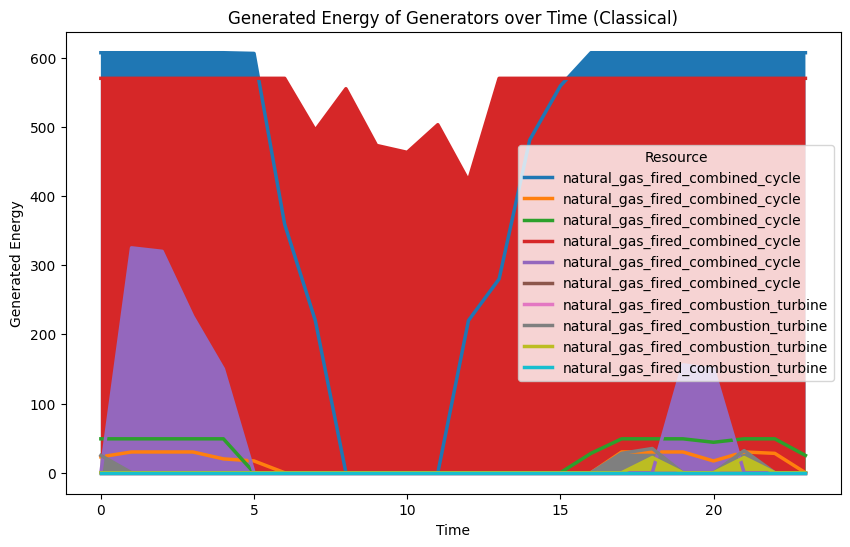

In [40]:
# Sort the DataFrame by the Generator and Time columns
data_df.sort_values(['Generator', 'Time'], inplace=True)

# Create the stacked area plot
plt.figure(figsize=(10, 6))
for generator, df_group in data_df.groupby('Generator'):
    sns.lineplot(x='Time', y='Generated Energy classical', data=df_group, linewidth=2.5, label=df_group.iloc[0]['Resource'])
    plt.fill_between(df_group['Time'], df_group['Generated Energy classical'], alpha=1)  # Fill area below the lines
plt.xlabel('Time')
plt.ylabel('Generated Energy')
plt.title('Generated Energy of Generators over Time (Classical)')
plt.legend(title='Resource')
plt.show()